# Library Imports

In [1]:
#Basic Data Operations Library
import pandas as pd
import numpy as np

#Visualisation & Plotting Library
import seaborn as sns
import matplotlib.pyplot as plt

#Library for (De)serialization for model reuse
import joblib

#Core libraries for machine learning pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, RocCurveDisplay, roc_curve

# Data Loading + Analysis

In [2]:
df = pd.read_csv('./diabetes_prediction_dataset.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


In [4]:
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [5]:
df.tail()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
99995,Female,80.0,0,0,No Info,27.32,6.2,90,0
99996,Female,2.0,0,0,No Info,17.37,6.5,100,0
99997,Male,66.0,0,0,former,27.83,5.7,155,0
99998,Female,24.0,0,0,never,35.42,4.0,100,0
99999,Female,57.0,0,0,current,22.43,6.6,90,0


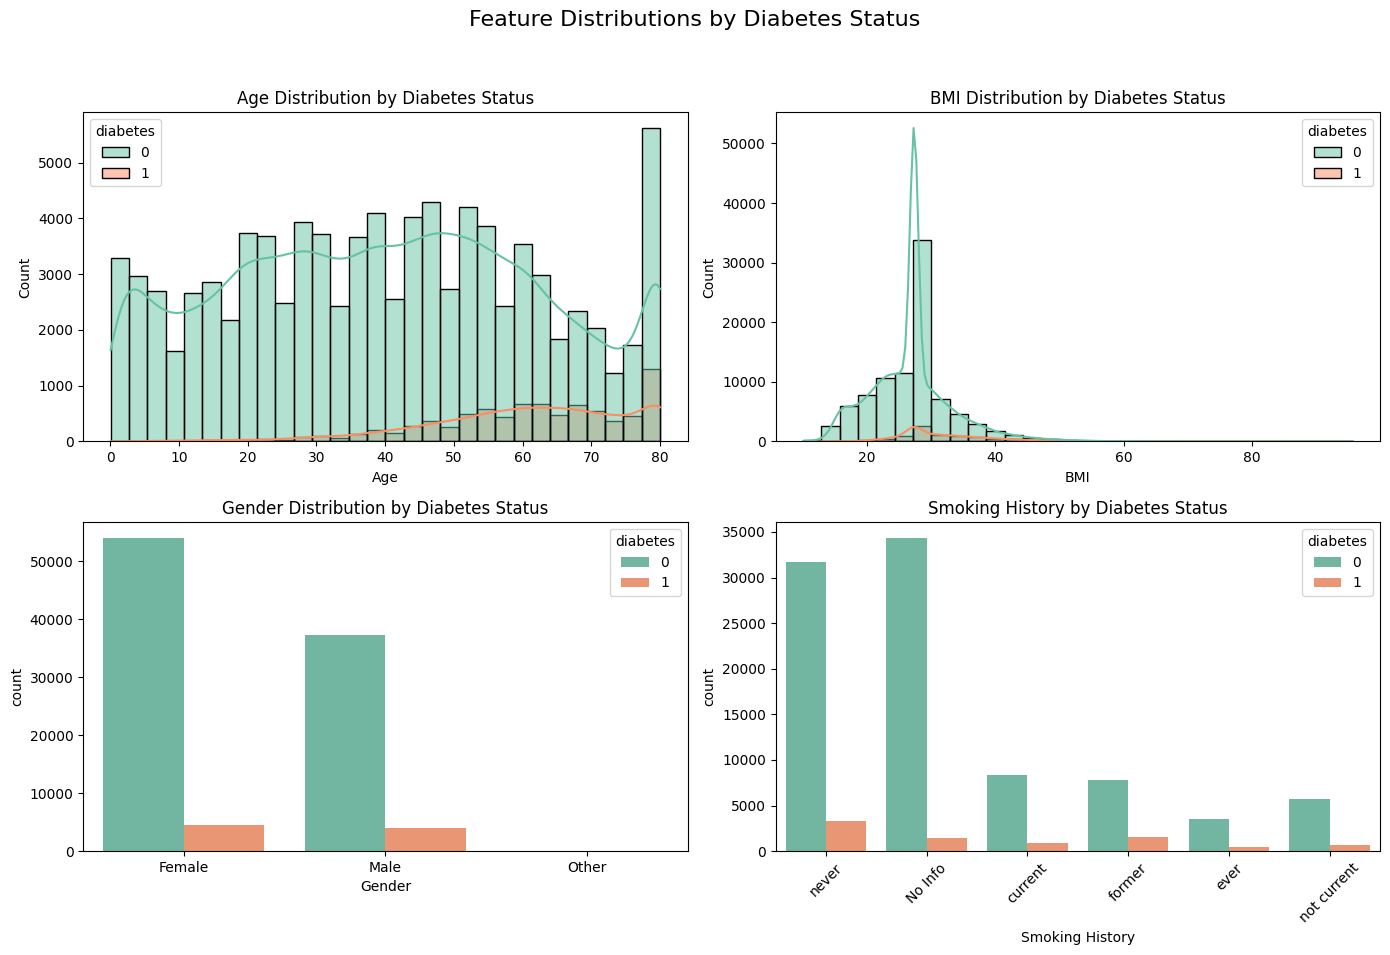

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Age distribution
sns.histplot(data=df, x='age', hue='diabetes', bins=30, ax=axes[0, 0], kde=True, palette='Set2')
axes[0, 0].set_title('Age Distribution by Diabetes Status')
axes[0, 0].set_xlabel('Age')

# BMI distribution
sns.histplot(data=df, x='bmi', hue='diabetes', bins=30, ax=axes[0, 1], kde=True, palette='Set2')
axes[0, 1].set_title('BMI Distribution by Diabetes Status')
axes[0, 1].set_xlabel('BMI')

# Gender countplot
sns.countplot(data=df, x='gender', hue='diabetes', ax=axes[1, 0], palette='Set2')
axes[1, 0].set_title('Gender Distribution by Diabetes Status')
axes[1, 0].set_xlabel('Gender')

# Smoking history countplot
sns.countplot(data=df, x='smoking_history', hue='diabetes', ax=axes[1, 1], palette='Set2')
axes[1, 1].set_title('Smoking History by Diabetes Status')
axes[1, 1].set_xlabel('Smoking History')
axes[1, 1].tick_params(axis='x', rotation=45)

fig.suptitle('Feature Distributions by Diabetes Status', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# Data Preprocessing (Encoding, Splitting, Class Balancing, Normalization)

In [7]:
df['smoking_history']

0          never
1        No Info
2          never
3        current
4        current
          ...   
99995    No Info
99996    No Info
99997     former
99998      never
99999    current
Name: smoking_history, Length: 100000, dtype: object

In [8]:
smoking_mapping = {
    "never": 0,
    "No Info": -1, 
    "current": 2,
    "former": 1
}

df["smoking_history"] = df["smoking_history"].map(smoking_mapping)
df["smoking_history"] = df["smoking_history"].map(smoking_mapping).fillna(-1)

In [9]:
df['gender']

0        Female
1        Female
2          Male
3        Female
4          Male
          ...  
99995    Female
99996    Female
99997      Male
99998    Female
99999    Female
Name: gender, Length: 100000, dtype: object

In [10]:
gender_mapping = {
    "Female": 0,
    "Male": 1
}

df['gender'] = df['gender'].map(gender_mapping)
df["gender"] = df["gender"].map(gender_mapping).fillna(-1)


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  float64
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  float64
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(5), int64(4)
memory usage: 6.9 MB


In [12]:
# Count the number of diabetic and non-diabetic cases in the dataset
diabetes_counts = df['diabetes'].value_counts()
print("Not diabetic:", diabetes_counts.get(0, 0))
print("Diabetic:", diabetes_counts.get(1, 0))

Not diabetic: 91500
Diabetic: 8500


In [13]:
# Split the data into features and target variable
X = df.drop('diabetes', axis=1)
y = df['diabetes']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Show class distribution after SMOTE
print(pd.Series(y_train_balanced).value_counts())

diabetes
0    73208
1    73208
Name: count, dtype: int64


In [14]:
# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test)

# Model Exploration (RF excluded)

              precision    recall  f1-score   support

           0       0.99      0.87      0.93     18292
           1       0.40      0.92      0.55      1708

    accuracy                           0.87     20000
   macro avg       0.69      0.89      0.74     20000
weighted avg       0.94      0.87      0.89     20000



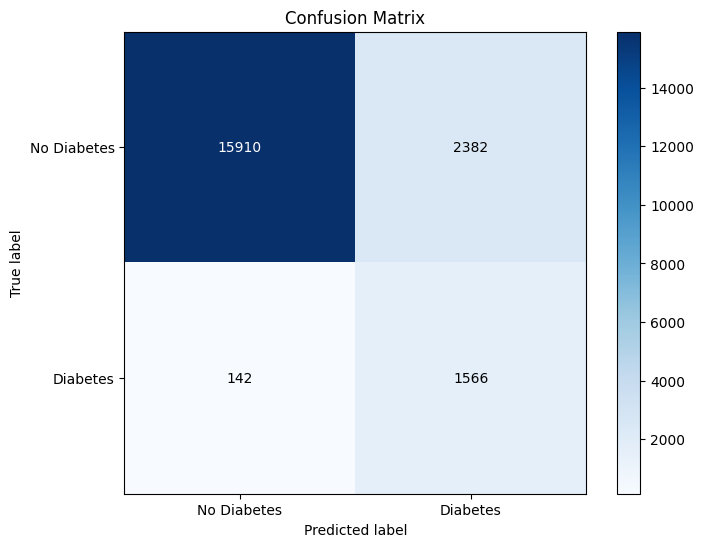

In [16]:
#SVC (Support Vector Machine)
from sklearn.svm import SVC

model_svc = SVC()
model_svc.fit(X_train_scaled, y_train_balanced)

y_pred_svc = model_svc.predict(X_test_scaled)

classification_report(y_test, y_pred_svc)
print(classification_report(y_test, y_pred_svc))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_svc)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks(np.arange(2), ['No Diabetes', 'Diabetes'])
plt.yticks(np.arange(2), ['No Diabetes', 'Diabetes'])
plt.xlabel('Predicted label')
plt.ylabel('True label')

# Show numbers in each cell
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > cm.max() / 2. else "black")

plt.show()

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     18292
           1       0.86      0.72      0.79      1708

    accuracy                           0.97     20000
   macro avg       0.92      0.86      0.88     20000
weighted avg       0.96      0.97      0.96     20000



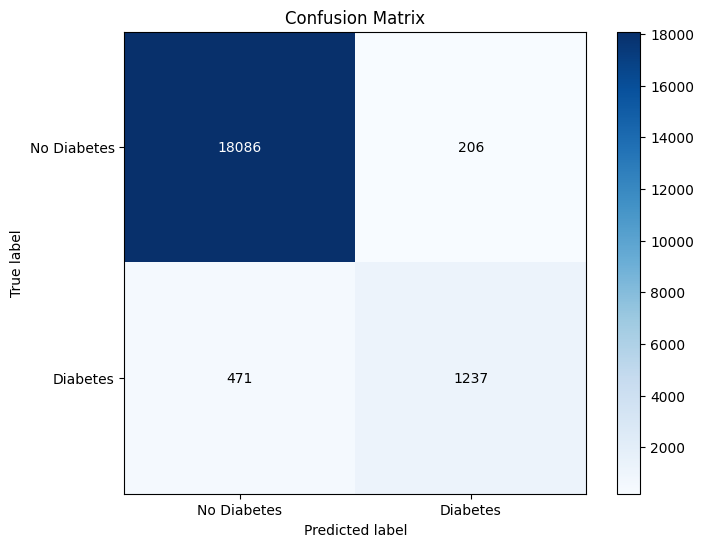

In [17]:
#XGBoost
from xgboost import XGBClassifier
model_xg = XGBClassifier()
model_xg.fit(X_train_scaled, y_train_balanced)

y_pred_xg = model_xg.predict(X_test_scaled)
print(classification_report(y_test, y_pred_xg))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_xg)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks(np.arange(2), ['No Diabetes', 'Diabetes'])
plt.yticks(np.arange(2), ['No Diabetes', 'Diabetes'])
plt.xlabel('Predicted label')
plt.ylabel('True label')

# Show numbers in each cell
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > cm.max() / 2. else "black")

plt.show()

              precision    recall  f1-score   support

           0       0.99      0.88      0.93     18292
           1       0.40      0.88      0.55      1708

    accuracy                           0.88     20000
   macro avg       0.70      0.88      0.74     20000
weighted avg       0.94      0.88      0.90     20000



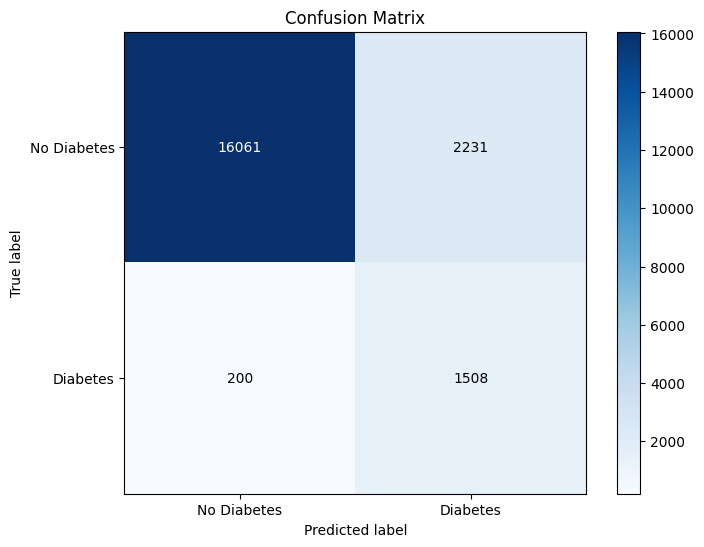

In [18]:
#XGBoost (XGBRF)
from xgboost import XGBRFClassifier
model_xgf = XGBRFClassifier()
model_xgf.fit(X_train_scaled, y_train_balanced)

y_pred_xgf = model_xgf.predict(X_test_scaled)
print(classification_report(y_test, y_pred_xgf))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_xgf)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks(np.arange(2), ['No Diabetes', 'Diabetes'])
plt.yticks(np.arange(2), ['No Diabetes', 'Diabetes'])
plt.xlabel('Predicted label')
plt.ylabel('True label')

# Show numbers in each cell
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > cm.max() / 2. else "black")

plt.show()

# Random Forest Classifier (Training - Post Training - Metrics)

In [19]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train_balanced)

RandomForestClassifier(random_state=42)

In [20]:
help(RandomForestClassifier)

Help on class RandomForestClassifier in module sklearn.ensemble._forest:

class RandomForestClassifier(ForestClassifier)
 |  RandomForestClassifier(n_estimators=100, *, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None, monotonic_cst=None)
 |
 |  A random forest classifier.
 |
 |  A random forest is a meta estimator that fits a number of decision tree
 |  classifiers on various sub-samples of the dataset and uses averaging to
 |  improve the predictive accuracy and control over-fitting.
 |  Trees in the forest use the best split strategy, i.e. equivalent to passing
 |  `splitter="best"` to the underlying :class:`~sklearn.tree.DecisionTreeClassifier`.
 |  The sub-sample size is controlled with the `max_samples` parameter i

In [21]:
import os

# dump trained model
model_path = "../model/diabetes_model.joblib"

if os.path.exists(model_path):
    model, scaler = joblib.load(model_path)
    print("Loaded existing model and scaler.")
else:
    with open('diabetes_model.joblib', 'wb') as f:
        joblib.dump((model, scaler), model_path)
    print("Trained model and scaler saved.")


Trained model and scaler saved.


In [22]:
y_pred = model.predict(X_test_scaled)
y_proba = model.predict_proba(X_test_scaled)[:, 1]

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     18292
           1       0.77      0.74      0.75      1708

    accuracy                           0.96     20000
   macro avg       0.87      0.86      0.87     20000
weighted avg       0.96      0.96      0.96     20000



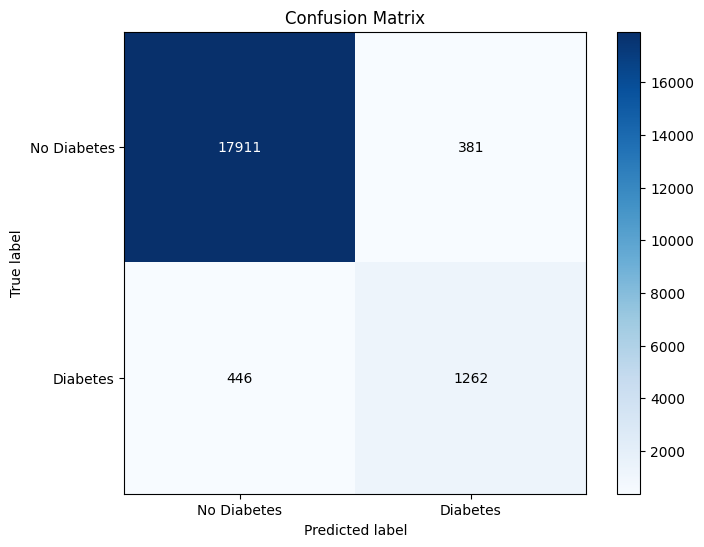

In [23]:
classification_report(y_test, y_pred)
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, model.predict(X_test_scaled))
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks(np.arange(2), ['No Diabetes', 'Diabetes'])
plt.yticks(np.arange(2), ['No Diabetes', 'Diabetes'])
plt.xlabel('Predicted label')
plt.ylabel('True label')

# Show numbers in each cell
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > cm.max() / 2. else "black")

plt.show()

In [24]:
roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC-AUC Score: {roc_auc:.4f}")

ROC-AUC Score: 0.9612


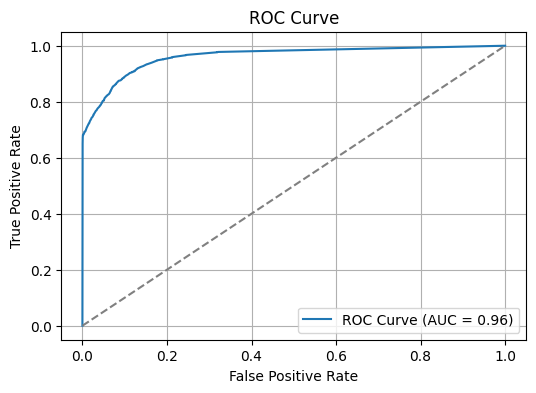

In [25]:
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()